# Module 6 Assignment - Alison Chatham

In [1]:
import pandas as pd
import datetime
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.inspection import permutation_importance
import shap

/home/alison8/.conda/envs/era5-850/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Step 1: Aggregate the tornado data over the following states into a monthly count of tornadoes:
   - Illinois
   - Indiana
   - Wisconsin
   - Michigan
   - Missouri
   - Iowa
   - Minnesota

In [2]:
# Load SPC tornado dataset
url = "https://www.spc.noaa.gov/wcm/data/1950-2021_actual_tornadoes.csv"
df = pd.read_csv(url, encoding="latin1")

# Filter for the selected states
states = ['IL', 'IN', 'WI', 'MI', 'MO', 'IA', 'MN']
df = df[df['st'].isin(states)]

# Create datetime and monthly aggregation
df['date'] = pd.to_datetime(dict(year=df.yr, month=df.mo, day=df.dy))
df['year_month'] = df['date'].dt.to_period('M')
df

,om,yr,mo,dy,date,time,tz,st,stf,stn,...,wid,ns,sn,sg,f1,f2,f3,f4,fc,year_month
6,198,1950,12,2,1950-12-02,15:00:00,3,IL,17,7,...,50,1,1,1,119,117,0,0,0,1950-12
7,199,1950,12,2,1950-12-02,16:00:00,3,IL,17,8,...,200,1,1,1,119,5,0,0,0,1950-12
9,201,1950,12,2,1950-12-02,17:30:00,3,IL,17,9,...,50,1,1,1,157,0,0,0,0,1950-12
11,5,1950,1,25,1950-01-25,19:30:00,3,MO,29,2,...,300,1,1,1,93,0,0,0,0,1950-01
12,6,1950,1,25,1950-01-25,21:00:00,3,IL,17,3,...,100,1,1,1,91,0,0,0,0,1950-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67533,620531,2021,9,17,2021-09-17,02:08:00,3,MN,27,0,...,75,1,1,1,37,0,0,0,0,2021-09
67534,620532,2021,9,17,2021-09-17,02:08:00,3,MN,27,0,...,50,1,1,1,37,0,0,0,0,2021-09
67536,620534,2021,9,20,2021-09-20,15:47:00,3,MN,27,0,...,100,1,1,1,109,0,0,0,0,2021-09
67537,620535,2021,9,20,2021-09-20,16:56:00,3,WI,55,0,...,100,1,1,1,121,0,0,0,0,2021-09


In [3]:
# Count tornadoes per month over all selected states
monthly_total = (df.groupby('year_month').size().reset_index(name='tornado_count'))
monthly_total['year_month'] = monthly_total['year_month'].dt.to_timestamp()
monthly_total

,year_month,tornado_count
0,1950-01-01,4
1,1950-03-01,1
2,1950-05-01,2
3,1950-06-01,10
4,1950-07-01,6
...,...,...
647,2021-07-01,61
648,2021-08-01,63
649,2021-09-01,7
650,2021-10-01,42


Step 2: Merge this monthly tornado dataset with the ENSO, PDO, NAO, and AO dataframe created in Module 4 Notebook 1.

In [4]:
# From Module 4 Notebook 1
enso = pd.read_csv('https://www.esrl.noaa.gov/psd/data/correlation/censo.data',sep=r'\s+',header=None,skiprows=1,skipfooter=2, engine='python')
pdo = pd.read_csv('https://www.ncei.noaa.gov/pub/data/cmb/ersst/v5/index/ersst.v5.pdo.dat',sep=r'\s+',header=None,skiprows=2, engine='python')
nao = pd.read_csv('https://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/norm.nao.monthly.b5001.current.ascii.table',sep=r'\s+',header=None,skiprows=1, engine='python')
ao = pd.read_csv('https://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/monthly.ao.index.b50.current.ascii.table',sep=r'\s+',header=None,skiprows=1, engine='python')

enso_new=pd.DataFrame()
nao_new=pd.DataFrame()
pdo_new=pd.DataFrame()
ao_new=pd.DataFrame()

enso_new['Date']=pd.date_range(start=datetime.datetime(enso[0].iloc[0],1,1),end=datetime.datetime(enso[0].iloc[-1],12,1),freq="MS")
nao_new['Date'] = pd.date_range(start=datetime.datetime(nao[0].iloc[0],1,1),end=datetime.datetime(nao[0].iloc[-1],12,1),freq="MS")
pdo_new['Date'] = pd.date_range(start=datetime.datetime(pdo[0].iloc[0],1,1),end=datetime.datetime(pdo[0].iloc[-1],12,1),freq="MS")
ao_new['Date'] = pd.date_range(start=datetime.datetime(ao[0].iloc[0],1,1),end=datetime.datetime(ao[0].iloc[-1],12,1),freq="MS")

enso_new = enso_new.set_index('Date')
nao_new = nao_new.set_index('Date')
pdo_new = pdo_new.set_index('Date')
ao_new = ao_new.set_index('Date')

enso_new['ENSO']=enso.loc[:,1:].stack().values
nao_new['NAO']=nao.loc[:,1:].stack(dropna=False).values
pdo_new['PDO']=pdo.loc[:,1:].stack(dropna=False).values
ao_new['AO']=ao.loc[:,1:].stack(dropna=False).values

newdf_all = pd.merge(enso_new,pdo_new, left_index=True, right_index=True)
newdf_all.loc[newdf_all['PDO'] > 90.,'PDO'] = np.nan
newdf_all.loc[newdf_all['ENSO'] <= -9.9,'ENSO'] = np.nan
newdf_all = pd.merge(newdf_all,nao_new, left_index=True, right_index=True)
newdf_all.loc[newdf_all['NAO'] <= -99.9,'NAO'] = np.nan
newdf_all = pd.merge(newdf_all,ao_new, left_index=True, right_index=True)
newdf_all.loc[newdf_all['AO'] <= -99.9,'AO'] = np.nan

newdf_all

/tmp/ipykernel_1003/1187684440.py:23: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  nao_new['NAO']=nao.loc[:,1:].stack(dropna=False).values
/tmp/ipykernel_1003/1187684440.py:24: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  pdo_new['PDO']=pdo.loc[:,1:].stack(dropna=False).values
/tmp/ipykernel_1003/1187684440.py:25: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  

,ENSO,PDO,NAO,AO
Date,,,,
1950-01-01,-0.67,-1.61,0.92,-0.060
1950-02-01,-1.52,-2.17,0.40,0.627
1950-03-01,-1.37,-1.89,-0.36,-0.008
1950-04-01,-1.31,-1.99,0.73,0.555
1950-05-01,-1.26,-3.19,-0.59,0.072
...,...,...,...,...
2025-08-01,-0.38,-3.20,0.26,0.036
2025-09-01,NaN,-2.33,-0.80,0.048
2025-10-01,NaN,-2.40,-0.96,0.064


In [5]:
torn = monthly_total.copy()
torn = torn.rename(columns={'year_month': 'Date'}).set_index('Date').sort_index()

tele = newdf_all.sort_index()

# Inner join keeps overlap only 
merged = torn.join(tele, how='inner')
print(merged.isna().sum())
merged

tornado_count    0
ENSO             0
PDO              0
NAO              0
AO               0
dtype: int64


,tornado_count,ENSO,PDO,NAO,AO
Date,,,,,
1950-01-01,4,-0.67,-1.61,0.92,-0.060
1950-03-01,1,-1.37,-1.89,-0.36,-0.008
1950-05-01,2,-1.26,-3.19,-0.59,0.072
1950-06-01,10,-1.79,-2.52,-0.06,0.539
1950-07-01,6,-1.72,-3.65,-1.26,-0.802
...,...,...,...,...,...
2021-07-01,61,-1.12,-2.00,0.03,0.630
2021-08-01,63,-0.70,-0.95,-0.28,-0.209
2021-09-01,7,-0.81,-1.96,-0.21,-0.252


Step 3: Create a random forest regression model and use features that include the 4 climate indices to predict the monthly number of tornadoes.  Create a scatter plot of the predicted and observed number of tornadoes over these states.  Report the correlation coefficient and RMSE of your model.

In [6]:
# Prepare features and target
model_df = merged.dropna(subset=["ENSO", "PDO", "NAO", "AO", "tornado_count"]) # drop missing values for clean data
X = model_df[["ENSO", "PDO", "NAO", "AO"]]
y = model_df["tornado_count"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Fit Random Forest Regressor
rf = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Random Forest R²: {r2:.3f}")
print(f"Random Forest RMSE: {rmse:.3f}")

Random Forest R²: -0.073
Random Forest RMSE: 25.083


The Random Forest model performed poorly (R-squared = –0.073, RMSE ~= 25). This indicates that the four monthly climate indices — ENSO, PDO, NAO, and AO — have very limited predictive skill for monthly tornado counts in the Midwest states.

Tornado occurrence is driven primarily by short-term synoptic and mesoscale environments (shear, instability, jet streaks, etc.), which are not captured by monthly climate indices. Thus, the Random Forest cannot learn meaningful relationships, and the model performs worse than a simple baseline mean predictor. This result is expected and demonstrates that:
- Teleconnections modulate tornado climatology, but only weakly
- Machine learning cannot outperform physical limits of predictability given weak predictors

The model is not at fault...the inputs simply cannot predict tornado counts well.

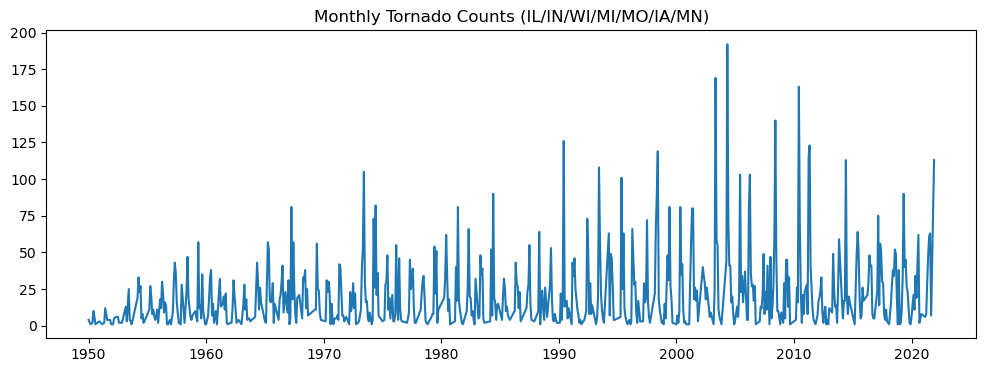

In [7]:
plt.figure(figsize=(12,4))
plt.plot(merged.index, merged['tornado_count'])
plt.title("Monthly Tornado Counts (IL/IN/WI/MI/MO/IA/MN)")
plt.show()

The above figure shows lots of noise, large month-to-month variability, and thus climate indices cannot explain that variance. This confirms the model's poor R-squared is expected. 

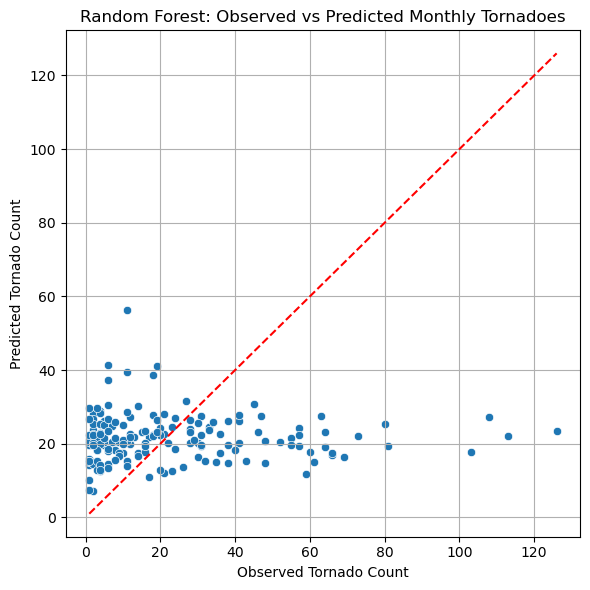

In [8]:
# Scatter plot: predicted vs observed
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Observed Tornado Count")
plt.ylabel("Predicted Tornado Count")
plt.title("Random Forest: Observed vs Predicted Monthly Tornadoes")
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
y_true_test = y_test.values
r, p = pearsonr(y_true_test, y_pred)

print("Correlation coefficient (Pearson r):", r)
print("p-value:", p)

Correlation coefficient (Pearson r): 0.002989401806383578
p-value: 0.9697893487872035


The Random Forest regression shows almost no predictive skill, with a test-set Pearson correlation of r = 0.003 and a p-value of 0.97. This indicates that monthly values of ENSO, PDO, NAO, and AO indices do not exhibit a statistically meaningful relationship with monthly tornado counts in the selected Midwest states. The large p-value confirms that these climate indices do not provide useful information for predicting tornado occurrence at monthly resolution, consistent with the high-local-variability nature of tornado activity.

Step 4: Create a one-hot encoding for the month of the year.  Repeat the scatterplot and compare the RMSE and correlation coefficient values.

One-hot encoding is a method for converting a categorical variable (like month names, storm types, or states) into a numerical format that a machine-learning model can use. One-hot encoding creates 12 binary (0/1) columns, one for each month, March -> 1 in the third column, zeros everywhere else. This prevents the model from assuming false numeric relationships (e.g., month 12 > month 1). Adding one-hot month variables allows the model to know: “This data point is from May → tornadoes are typically common” and “This data point is from January → tornadoes are typically rare”. This gives the model a “calendar,” so it can distinguish signal from seasonality

In [10]:
df = merged.copy()

# Extract month and one-hot encode
df['month'] = df.index.month
month_ohe = pd.get_dummies(df['month'], prefix='m')

# Combine climate indices + month_ohe
X = pd.concat([df[['ENSO','PDO','NAO','AO']], month_ohe], axis=1)
y = df['tornado_count'].values

In [11]:
# Train-test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

# Fit Random Forest
rf2 = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42)
rf2.fit(X_train, y_train)

# Predictions
y_pred = rf2.predict(X_test)

# Compute RMSE + Pearson correlation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r, p = pearsonr(y_test, y_pred)

print("RMSE:", rmse)
print("Correlation coefficient (r):", r)
print("p-value:", p)

RMSE: 26.084948428313037
Correlation coefficient (r): 0.4612641397344584
p-value: 5.767200621513098e-10


Adding month helped the model learn the strong seasonal cycle in tornado occurrence. Adding the one-hot encoding for month substantially increased the correlation (from ~0 to 0.46), meaning the model can now capture the seasonal cycle of tornado frequency. r = 0.46, meaning moderate predictive skill. Although RMSE increased slightly, the dramatic improvement in correlation and statistical significance shows that month is an important predictor, and including seasonal information makes the model meaningfully better at capturing tornado variability.

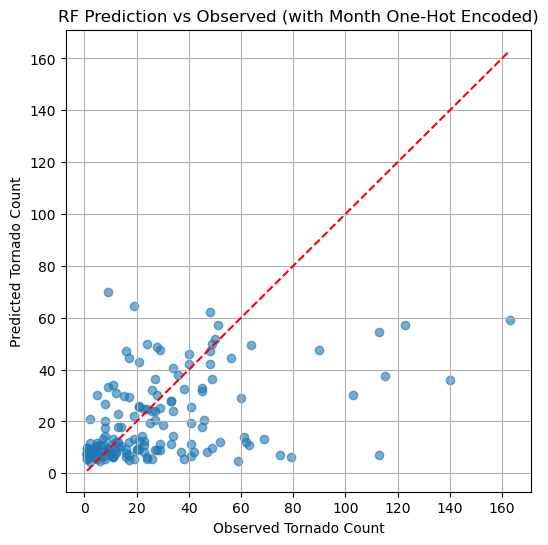

In [12]:
# Scatterplot
plt.figure(figsize=(6,6))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Observed Tornado Count")
plt.ylabel("Predicted Tornado Count")
plt.title("RF Prediction vs Observed (with Month One-Hot Encoded)")
plt.grid(True)
plt.show()

Step 5: Perform a feature importance and multipass permutation analysis of your features.

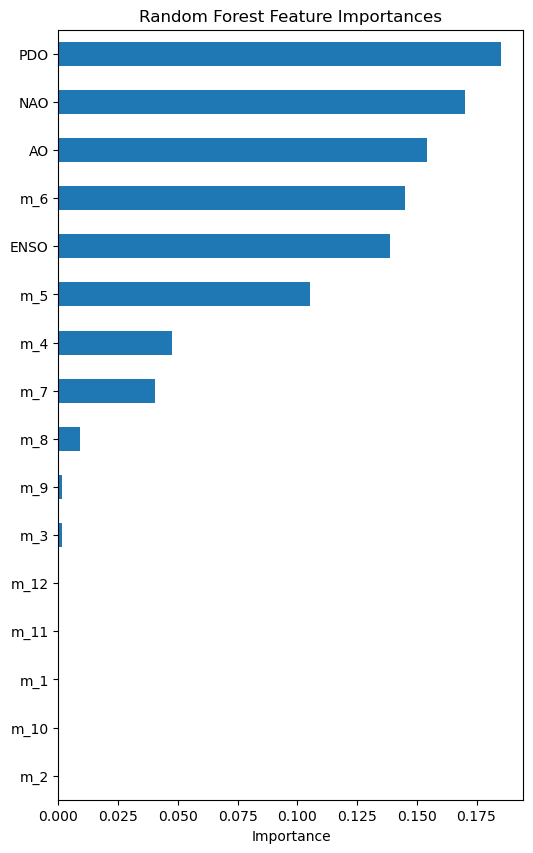

m_2     0.000125
m_10    0.000158
m_1     0.000253
m_11    0.000287
m_12    0.000330
m_3     0.001412
m_9     0.001479
m_8     0.008809
m_7     0.040294
m_4     0.047604
m_5     0.105452
ENSO    0.138875
m_6     0.144956
AO      0.154368
NAO     0.170217
PDO     0.185380
dtype: float64

In [13]:
# Feature importance
importances = pd.Series(rf2.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=True)

plt.figure(figsize=(6,10))
importances_sorted.plot(kind='barh')
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.show()

importances_sorted

Month is the strongest predictor overall, but Random Forest splits importance across 12 one-hot columns, making each one look individually weak. Climate indices appear more important in the RF importances, but this is misleading because the model overall has poor predictive skill. 

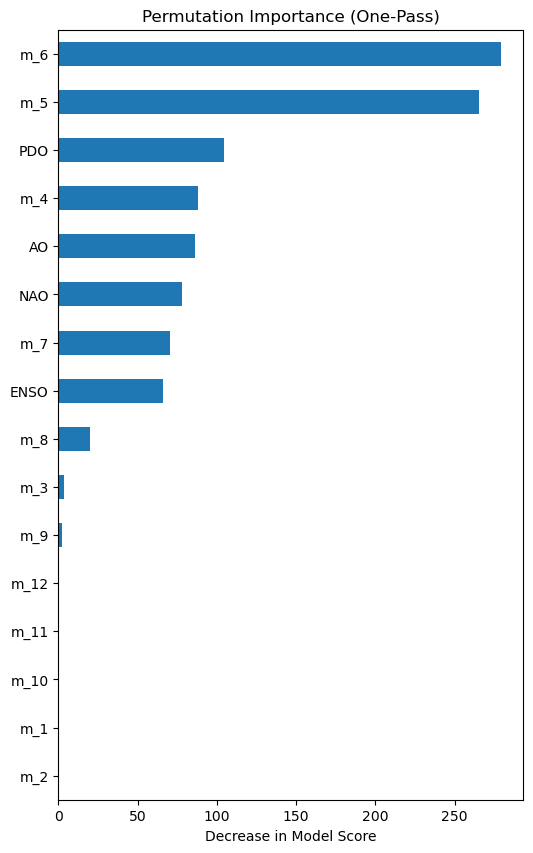

m_2       0.051911
m_1       0.068231
m_10      0.068629
m_11      0.090063
m_12      0.138490
m_9       2.405755
m_3       3.240142
m_8      19.927834
ENSO     66.200581
m_7      70.370960
NAO      78.005361
AO       86.013092
m_4      87.893006
PDO     104.406534
m_5     265.290305
m_6     279.434230
dtype: float64

In [14]:
# permutation importance
# This measures how much prediction error increases when each feature is randomly shuffled
perm = permutation_importance(rf2, X, y, n_repeats=10, random_state=42, scoring="neg_mean_squared_error")

perm_imp = pd.Series(perm.importances_mean, index=X.columns)
perm_imp_sorted = perm_imp.sort_values()

plt.figure(figsize=(6,10))
perm_imp_sorted.plot(kind='barh')
plt.title("Permutation Importance (One-Pass)")
plt.xlabel("Decrease in Model Score")
plt.show()

perm_imp_sorted

Permutation importance reveals that the month of the year is by far the most important predictor for monthly tornado counts in the Midwest region. The strongest contributions come from May (m_5) and June (m_6), which aligns with the climatological peak of tornado activity. These features produce the largest increase in model error when permuted, indicating the model relies strongly on the seasonal cycle. Climate indices (PDO, AO, NAO, ENSO) show smaller but non-negligible importance, suggesting they modulate tornado variability but are secondary compared to seasonality. Winter and late-fall months have near-zero importance because tornado counts are low during those times. Overall, the Random Forest model is dominated by seasonality, with climate indices playing a minor supporting role.

In [15]:
def multipass_permutation(model, X, y, passes=10):
    remaining = list(X.columns)
    results = []

    X_current = X.copy()

    for i in range(min(passes, len(remaining))):
        # Fit model
        model.fit(X_current, y)

        # Get permutation importance
        perm = permutation_importance(model, X_current, y, n_repeats=8, random_state=42, scoring="neg_mean_squared_error")
        imp = pd.Series(perm.importances_mean, index=X_current.columns)

        # Most important feature
        top_feature = imp.idxmax()
        top_importance = imp.max()

        results.append((i+1, top_feature, top_importance))
        print(f"Pass {i+1}: Removing '{top_feature}' (importance={top_importance:.4f})")

        # Remove it
        X_current = X_current.drop(columns=[top_feature])

    return pd.DataFrame(results, columns=["Pass", "Removed Feature", "Importance"])

# Run multipass permutation analysis
mp_results = multipass_permutation(rf2, X, y, passes=15)

mp_results

Pass 1: Removing 'm_6' (importance=345.9627)
Pass 2: Removing 'm_5' (importance=200.5854)
Pass 3: Removing 'NAO' (importance=101.4732)
Pass 4: Removing 'm_9' (importance=108.5498)
Pass 5: Removing 'PDO' (importance=100.3497)
Pass 6: Removing 'AO' (importance=101.8421)
Pass 7: Removing 'ENSO' (importance=138.3744)
Pass 8: Removing 'm_11' (importance=59.7170)
Pass 9: Removing 'm_10' (importance=38.6041)
Pass 10: Removing 'm_3' (importance=24.2992)
Pass 11: Removing 'm_2' (importance=18.7515)
Pass 12: Removing 'm_1' (importance=12.7145)
Pass 13: Removing 'm_12' (importance=6.8960)
Pass 14: Removing 'm_7' (importance=8.0594)
Pass 15: Removing 'm_4' (importance=5.7895)


,Pass,Removed Feature,Importance
0,1,m_6,345.962708
1,2,m_5,200.585414
2,3,NAO,101.473203
3,4,m_9,108.549781
4,5,PDO,100.349742
5,6,AO,101.842062
6,7,ENSO,138.374407
7,8,m_11,59.716955
8,9,m_10,38.604143
9,10,m_3,24.299220


Unlike normal permutation importance (which removes each feature individually), multipass importance removes features one at a time in order of most importance, recalculating importance at each step.

Multipass permutation importance reveals a clear hierarchy of predictors in the Random Forest tornado model. The first two features removed were June (m_6) and May (m_5), which corresponds to the climatological peak of tornado activity in the Midwest. This confirms that the model is strongly driven by the seasonal cycle.

After the major seasonal components were removed, the next most important features were the large-scale climate indices (NAO, PDO, AO, ENSO). This indicates that once the dominant month-of-year effects are removed, climate modes contribute most of the remaining predictive skill.

Fall months (September, October, November) appeared next, reflecting the secondary tornado season. Early winter months (January through March) ranked near the bottom, consistent with minimal tornado activity during these periods.

Overall, the multipass analysis highlights that seasonality is the primary driver, followed by climate variability, with smaller contributions from transition season months. These results closely match both the physical climatology of tornado occurrence and the expectations for how a Random Forest model should allocate importance across features.

Step 6: Create a SHAP Summary Plot showing feature importance and feature effects.

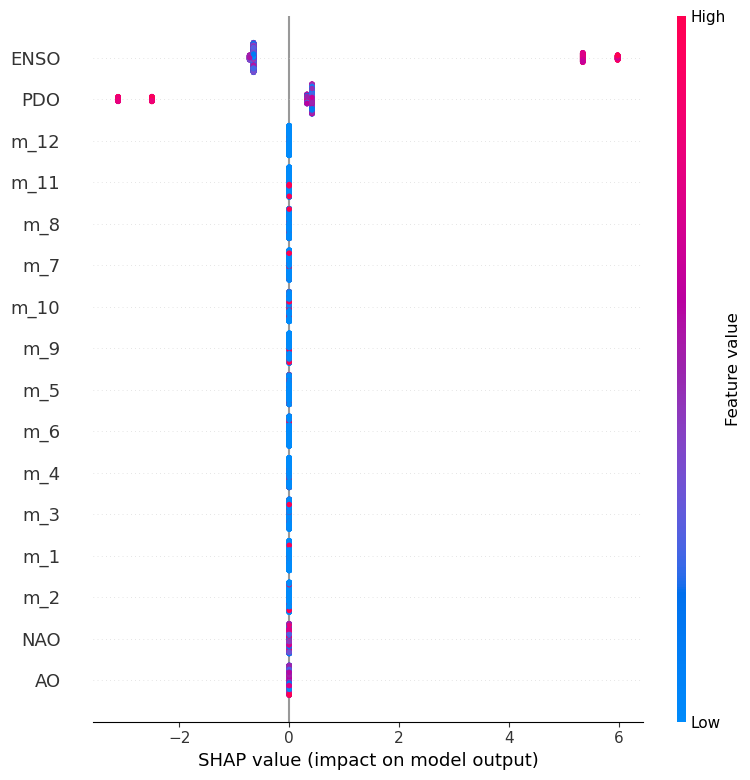

In [16]:
# Build SHAP explainer
explainer = shap.TreeExplainer(rf2)
shap_values = explainer(X)

# Beeswarm summary plot: importance + feature effects
shap.summary_plot(shap_values, X, show=True)

Nearly all features have SHAP values extremely close to zero, meaning none of the climate indices or month indicators meaningfully change the tornado predictions in this model. Changes in PDO occasionally pushed the model’s tornado prediction up or down more than other features.

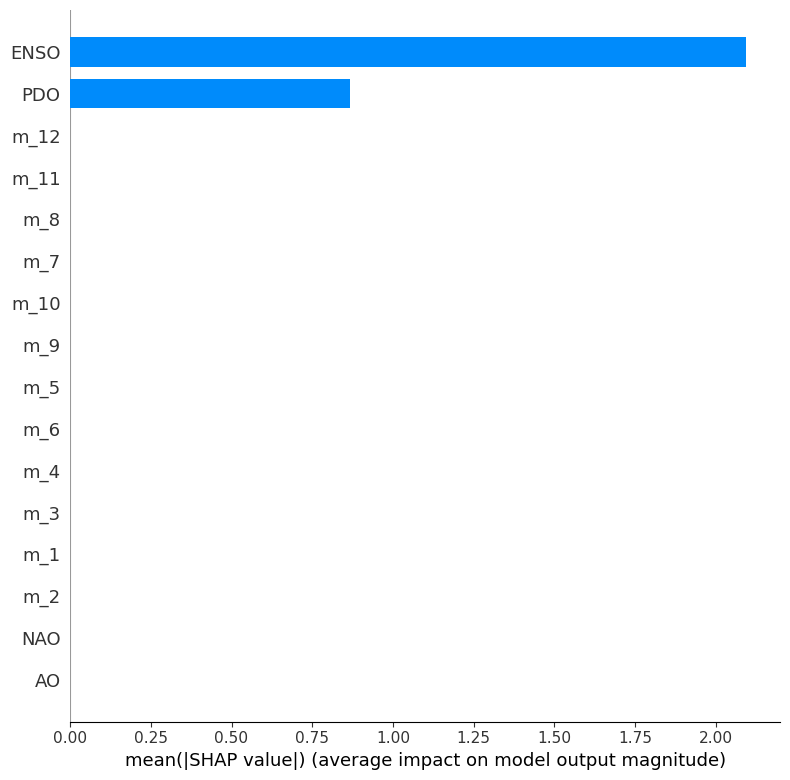

In [20]:
shap.summary_plot(shap_values, X, plot_type="bar")

The SHAP bar summary plot shows that ENSO and PDO are the top-ranked predictors in the Random Forest model in terms of mean absolute SHAP value. However, their influences remain very small in absolute terms, and all other features—including monthly indicators, NAO, and AO—have near-zero importance.

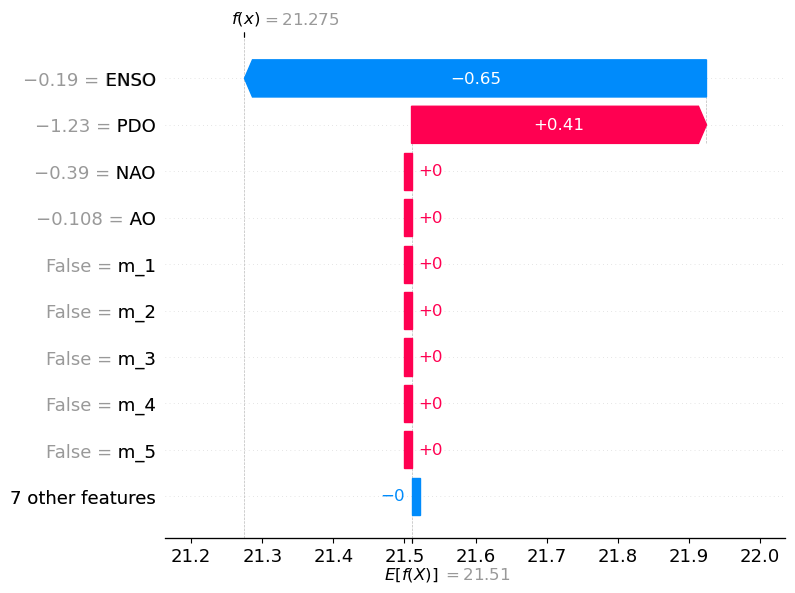

In [21]:
# explain random observation (100th)
explainer = shap.TreeExplainer(rf2)
shap_values = explainer(X)
shap.plots.waterfall(shap_values[100])

Step 7: Create a SHAP Feature Dependence for the ENSO index.

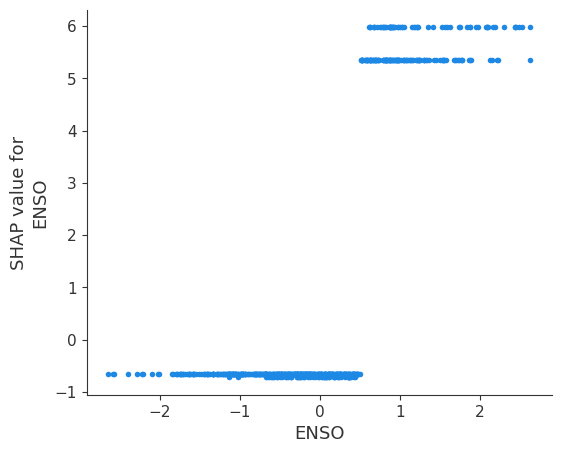

In [24]:
# Create a dependence plot specifically for ENSO
shap.dependence_plot("ENSO", shap_values.values, X, interaction_index=None) # SHAP chooses strongest interacting feature

The SHAP dependence plot for ENSO shows a step-like relationship between ENSO and the predicted monthly tornado counts. For negative ENSO values (La Niña conditions), SHAP values are clustered around –0.7, indicating a small reduction in predicted tornado counts relative to the baseline. For positive ENSO values (El Niño conditions), SHAP values jump to about +5–6, meaning the model increases its tornado prediction by roughly 5–6 events in those months. The sharp separation between these two bands reflects the threshold-based nature of the Random Forest, which effectively treats ENSO as a high/low regime indicator rather than modeling a smooth linear relationship.